In [1]:
using Pkg
using LinearAlgebra
using Plots
using Distributions
using Random
using StateSpaceDynamics
using StatsBase

const SSD = StateSpaceDynamics

StateSpaceDynamics

# Gaussian HMM

In [6]:
"""
Create an underlying GaussianHMM to generate data
"""

# Create Guassian Emission Models
output_dim = 2
μ = [0.0, 0.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

μ = [2.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)

# Create GaussianHMM
true_model = SSD.GaussianHMM(K=2, output_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2
true_model.A = [0.9 0.1; 0.8 0.2]

# Sample from the model
n=50000
true_labels, data = SSD.sample(true_model, n=n)

# Fit a gaussian hmm to the data
test_model = SSD.GaussianHMM(K=2, output_dim=2)
test_model.A = [0.8 0.2; 0.05 0.95]
ll = SSD.fit!(test_model, data)

print(isapprox(test_model.B[1].μ, true_model.B[1].μ, atol=0.1) || isapprox(test_model.B[1].μ, true_model.B[2].μ, atol=0.1))
print(isapprox(test_model.B[2].μ, true_model.B[2].μ, atol=0.1) || isapprox(test_model.B[2].μ, true_model.B[1].μ, atol=0.1))

truetrue

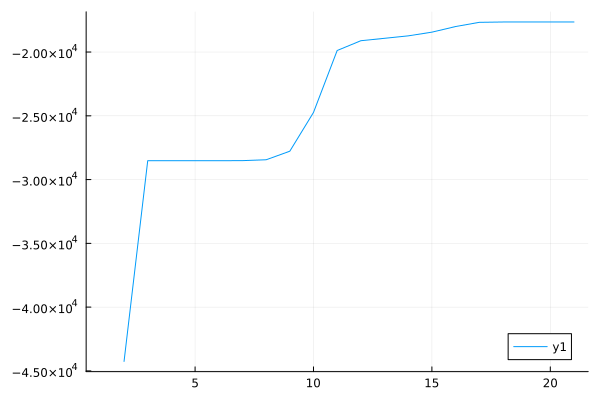

In [3]:
plot(ll)

# Switching Gaussian Regression #

In [35]:
# Create Emission Models
emission_1 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([3, 2, 2, 3], :, 1))
emission_2 = GaussianRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 3, 2], :, 1))

# Create Switching Regression Model
true_model = SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n = 20000
Φ = randn(n, 3)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Try to fit a new model to the data
test_model = SSD.SwitchingGaussianRegression(K=2, input_dim=3, output_dim=1, include_intercept=true)
ll = SSD.fit!(test_model, data, Φ)

# Test output -> not quite right yet
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))

truetrue

In [34]:
println(true_model.A)
println(test_model.A)

[0.12139689086507245 0.8786031091349276; 0.142008332672383 0.857991667327617]
[0.11833204319305747 0.8816679568069791; 0.14326271899632775 0.8567372810036702]


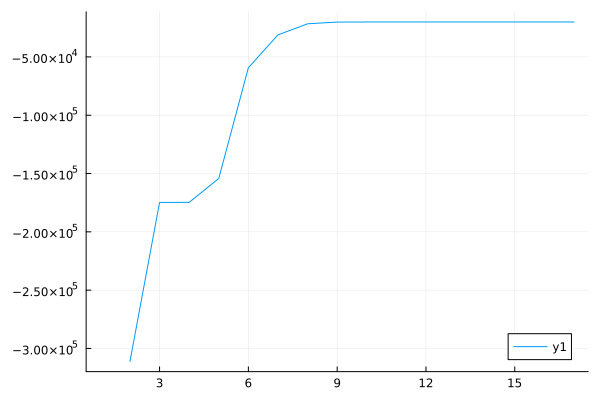

In [36]:
plot(ll)

# Switching Bernoulli Regression #

In [3]:
"""
Create Bernoulli Regression Model
"""
# Make Emission Models
emission_1 = SSD.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([3, 1, 8], :, 1))
emission_2 = SSD.BernoulliRegressionEmission(input_dim=2, output_dim=1, include_intercept=true, β = reshape([-4, -5, 0.1], :, 1))

# Create Switching Bernoulli Regression and add the emissions
true_model = SSD.SwitchingBernoulliRegression(K=2, input_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the model
n=20000
Φ = randn(n, 2)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Fit a new Bernoulli Regression Model to the data
test_model = SSD.SwitchingBernoulliRegression(K=2, input_dim=2)
ll = SSD.fit!(test_model, data, Φ, max_iters=200)

# # Test it works alright
print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.5) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.5))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.5) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.5))

truetrue

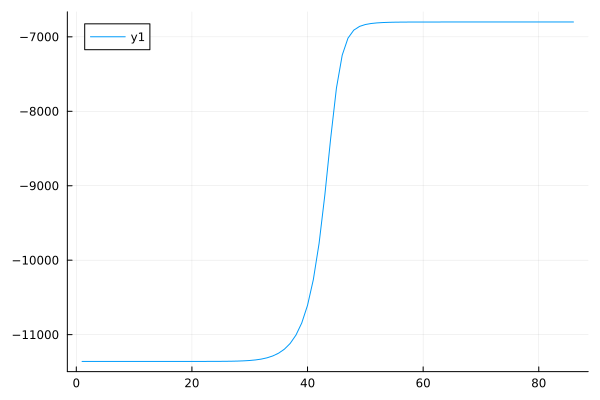

In [4]:
plot(ll[3:end])

# Switching Poisson Regression

In [37]:
"""
Create a Switching Poisson Regression
"""
# Create the emission models
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([4, 3, 2, 4], :, 1))
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-4, -2, 1, 3], :, 1))

# Initialize the SwitchingPoissonRegression
true_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=1)

# Plug in the emission models
true_model.B[1] = emission_1
true_model.B[2] = emission_2

# Sample from the HMM
n=20000
Φ = randn(n, 3)
true_labels, data = SSD.sample(true_model, Φ, n=n)

# Create a new SwitchingPoissonRegression and try to recover parameters
test_model = SwitchingPoissonRegression(K=2, input_dim=3, output_dim=1)

# Create the emission models for warm start
emission_1 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([2.0, 1.0, 4.0, 2.0], :, 1))
emission_2 = PoissonRegressionEmission(input_dim=3, output_dim=1, include_intercept=true, β=reshape([-5.0, -1.0, 0.0, 2.0], :, 1))
test_model.B[1], test_model.B[2] = emission_1, emission_2

ll = SSD.fit!(test_model, data, Φ, max_iters=200)

print(isapprox(test_model.B[1].β, true_model.B[1].β, atol=0.1) || isapprox(test_model.B[1].β, true_model.B[2].β, atol=0.1))
print(isapprox(test_model.B[2].β, true_model.B[2].β, atol=0.1) || isapprox(test_model.B[2].β, true_model.B[1].β, atol=0.1))


truetrue

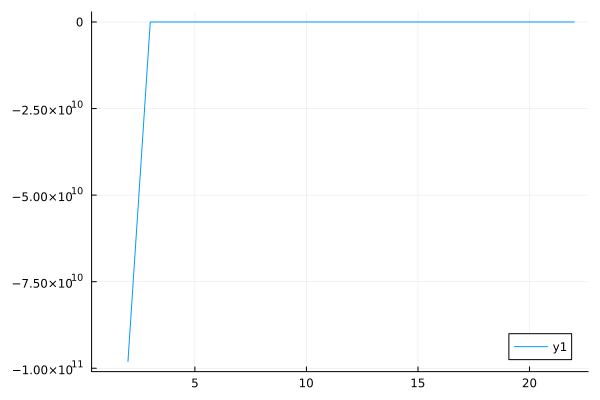

In [39]:
plot(ll)

In [6]:
# Create Guassian Emission Models
output_dim = 2
μ = [0.0, 0.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_1 = GaussianEmission(output_dim, μ, Σ)

μ = [2.0, 1.0]
Σ = 0.1 * Matrix{Float64}(I, output_dim, output_dim)
emission_2 = GaussianEmission(output_dim, μ, Σ)

# Create GaussianHMM
true_model = GaussianHMM(K=2, output_dim=2)
true_model.B[1] = emission_1
true_model.B[2] = emission_2
true_model.A = [0.9 0.1; 0.8 0.2]

# Sample from the model
n=20000
true_labels, data = StateSpaceDynamics.sample(true_model, n=n)

# Fit a new gaussian hmm to the data
test_model = GaussianHMM(K=2, output_dim=2)
ll = SSD.fit!(test_model, data)

23-element Vector{Float64}:
    -Inf
 -44430.14530702644
 -28608.92563745928
 -28608.909547786763
 -28608.743094886533
 -28607.017278166368
 -28589.143857908537
 -28410.23662999389
 -27030.73220545987
 -22168.657106515708
      ⋮
 -18962.486014551727
 -18756.528717794303
 -18412.609784424956
 -17905.023510139938
 -17627.625569040913
 -17617.658141737444
 -17617.6475796683
 -17617.64757184082
 -17617.647571826597

In [8]:
println(true_model.A)
println(test_model.A)

[0.9 0.1; 0.8 0.2]
[0.19725532294954548 0.8027446770504554; 0.102355836161429 0.8976441638385683]
